## AmpSF schematic generator solution
The follow cell contains the solution for AmpSF schematic generator.  you should be able to evaluate it and run the flow.  Note that it uses `amp_sf_soln` schematic template instead of the `amp_sf` schematic template you meant to fill out.  If you wish to debug your schematic template, you can change `amp_sf_soln` to `amp_sf` in the `yaml_file` class variable.

creating BagProject
computing layout
ext_w0 = 1, ext_wend=9, tot_ntr=20
ext_w0 = 2, ext_wend=8, tot_ntr=20
ext_w0 = 4, ext_wend=9, tot_ntr=21
final: ext_w0 = 2, ext_wend=8, tot_ntr=20
creating layout
layout done
creating AMP_SF schematics
running lvs
Running tasks, Press Ctrl-C to cancel.
lvs passed
lvs log is /tools/projects/erichang/bag_gen/BAG2_cds_ff_mpt/pvs_run/lvs_run_dir/DEMO_AMP_SF/AMP_SF/lvsLog_20171201_0800359c4dxn85
computing AMP_SF_tb_dc schematics
creating AMP_SF_tb_dc schematics
DEPRECATED WARNING: erase is no longer supported in implement_design() and has no effect
computing AMP_SF_tb_ac_tran schematics
creating AMP_SF_tb_ac_tran schematics
DEPRECATED WARNING: erase is no longer supported in implement_design() and has no effect
schematic done
setting up AMP_SF_tb_dc
running simulation
Running tasks, Press Ctrl-C to cancel.
simulation done, load results
setting up AMP_SF_tb_ac_tran
running simulation
Running tasks, Press Ctrl-C to cancel.
simulation done, load results
all

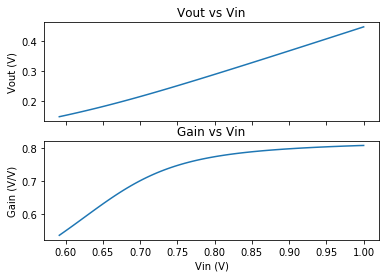

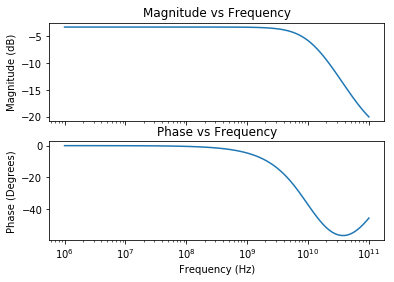

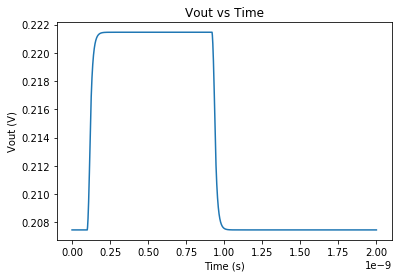

In [1]:
import os

from bag.design import Module


# noinspection PyPep8Naming
class demo_templates__amp_sf(Module):
    """Schematic generator for a source follower.
    """

    # hard coded netlist flie path to get jupyter notebook working.
    yaml_file = os.path.join(os.environ['BAG_WORK_DIR'], 'BAG_XBase_demo', 
                             'BagModules', 'demo_templates', 'netlist_info', 'amp_sf_soln.yaml') 

    def __init__(self, bag_config, parent=None, prj=None, **kwargs):
        Module.__init__(self, bag_config, self.yaml_file, parent=parent, prj=prj, **kwargs)

    @classmethod
    def get_params_info(cls):
        # type: () -> Dict[str, str]
        """Returns a dictionary from parameter names to descriptions.

        Returns
        -------
        param_info : Optional[Dict[str, str]]
            dictionary from parameter names to descriptions.
        """
        return dict(
            lch='channel length in meters.',
            w_dict='Dictionary of transistor widths.',
            intent_dict='Dictionary of transistor threshold flavors.',
            fg_dict='Dictionary of transistor number of fingers.',
        )

    def design(self, lch=18e-9, w_dict=None, intent_dict=None, fg_dict=None):
        """Set the parameters of source follower.
        """
        w_amp = w_dict['amp']
        w_bias = w_dict['bias']
        intent_amp = intent_dict['amp']
        intent_bias = intent_dict['bias']

        fg_amp = fg_dict['amp']
        fg_bias = fg_dict['bias']

        self.instances['XAMP'].design(w=w_amp, l=lch, intent=intent_amp, nf=fg_amp)
        self.instances['XBIAS'].design(w=w_bias, l=lch, intent=intent_bias, nf=fg_bias)

        # design dummies
        fg_dum_list = fg_dict['dum_list']
        num_dummies = len(fg_dum_list)
        name_list = ['XDUM%d' % idx for idx in range(num_dummies)]

        if (fg_amp - fg_bias) % 4 == 0:
            term_list = [{}, {}, dict(D='VDD')]
        else:
            term_list = [{}, {}, dict(D='vout')]

        self.array_instance('XDUM', name_list, term_list=term_list)
        self.instances['XDUM'][0].design(w=w_bias, l=lch, intent=intent_bias, nf=fg_dum_list[0])
        self.instances['XDUM'][1].design(w=w_amp, l=lch, intent=intent_amp, nf=fg_dum_list[1])
        self.instances['XDUM'][2].design(w=w_amp, l=lch, intent=intent_amp, nf=fg_dum_list[2])

        
import os

# import bag package
import bag
from bag.io import read_yaml

# import BAG demo Python modules
import xbase_demo.core as demo_core
from xbase_demo.demo_layout.core import AmpSFSoln

# load circuit specifications from file
spec_fname = os.path.join(os.environ['BAG_WORK_DIR'], 'specs_demo/demo.yaml')
top_specs = read_yaml(spec_fname)

# obtain BagProject instance
local_dict = locals()
if 'bprj' in local_dict:
    print('using existing BagProject')
    bprj = local_dict['bprj']
else:
    print('creating BagProject')
    bprj = bag.BagProject()

demo_core.run_flow(bprj, top_specs, 'amp_sf', AmpSFSoln, sch_cls=demo_templates__amp_sf, run_lvs=True)